In [3]:
from comet import COMET
# import datautils
from tasks.classification import eval_classification
from preprocessing.tdbrain_preprocessing import load_tdbrain

import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import copy
from sklearn.utils import shuffle
from utils import plot_channels
from utils import process_batch_trial
from utils import split_data_label
from utils import start_logging
from utils import stop_logging

from datetime import datetime

In [4]:
RANDOM_SEED = 41

def seed_everything(seed=42):
    """
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # training is extremely slow when do following setting
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.deterministic = True

# Autoload the modified python file
%reload_ext autoreload
%autoreload 2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
working_directory = 'test_run/TDBrain/'
dataset_save_path = working_directory
if not os.path.exists(working_directory):
    os.makedirs(working_directory)

logging_directory = 'logging/TDBrain/'
if not os.path.exists(logging_directory):
    os.makedirs(logging_directory)

In [6]:
data_path = "datasets/TDBRAIN/Feature/"
label_path = "datasets/TDBRAIN/Label/label.npy"
train_ids = list(range(1,18)) + list(range(29,46))
val_ids = [18, 19, 20, 21] + [46, 47, 48, 49]  # 8 subjects, 4 positive 4 healthy
test_ids = [22, 23, 24, 25] + [50, 51, 52, 53]  # 8 subjects, 4 positive 4 healthy"""
"""drop_ids = list(range(26,29)) + list(range(54,73))
trial_train_data, trial_val_data, trial_test_data, trial_train_labels, trial_val_labels, trial_test_labels = load_tdbrain(drop_ids, data_path, label_path)"""
trial_train_data, trial_val_data, trial_test_data, trial_train_labels, trial_val_labels, trial_test_labels = load_tdbrain(train_ids, val_ids, test_ids, data_path, label_path)
print(trial_train_data.shape)
print(trial_train_labels.shape)
print(trial_val_data.shape)
print(trial_val_labels.shape)
print(trial_test_data.shape)
print(trial_test_labels.shape)

Validation subjects:  [18, 19, 20, 21, 46, 47, 48, 49]
Test subjects:  [22, 23, 24, 25, 50, 51, 52, 53]
(432, 2560, 33)
(432, 2)
(96, 2560, 33)
(96, 2)
(96, 2560, 33)
(96, 2)


In [7]:
# normalize data
trial_train_data = process_batch_trial(trial_train_data, bandpass_filter=False)
trial_val_data = process_batch_trial(trial_val_data, bandpass_filter=False)
trial_test_data = process_batch_trial(trial_test_data, bandpass_filter=False)
print(trial_train_data.shape)
print(trial_val_data.shape)
print(trial_test_data.shape)

(432, 2560, 33)
(96, 2560, 33)
(96, 2560, 33)


In [8]:
# Split data and labels
sample_overlapping = 0.5
sample_train_data, sample_train_labels = split_data_label(trial_train_data,trial_train_labels, sub_length=256, overlapping=sample_overlapping)
sample_val_data, sample_val_labels = split_data_label(trial_val_data,trial_val_labels, sub_length=256, overlapping=sample_overlapping)
sample_test_data, sample_test_labels = split_data_label(trial_test_data,trial_test_labels, sub_length=256, overlapping=sample_overlapping)
print(sample_train_data.shape)
print(sample_val_data.shape)
print(sample_test_data.shape)
print(sample_train_labels.shape)
print(sample_val_labels.shape)
print(sample_test_labels.shape)

(8208, 256, 33)
(1824, 256, 33)
(1824, 256, 33)
(8208, 3)
(1824, 3)
(1824, 3)


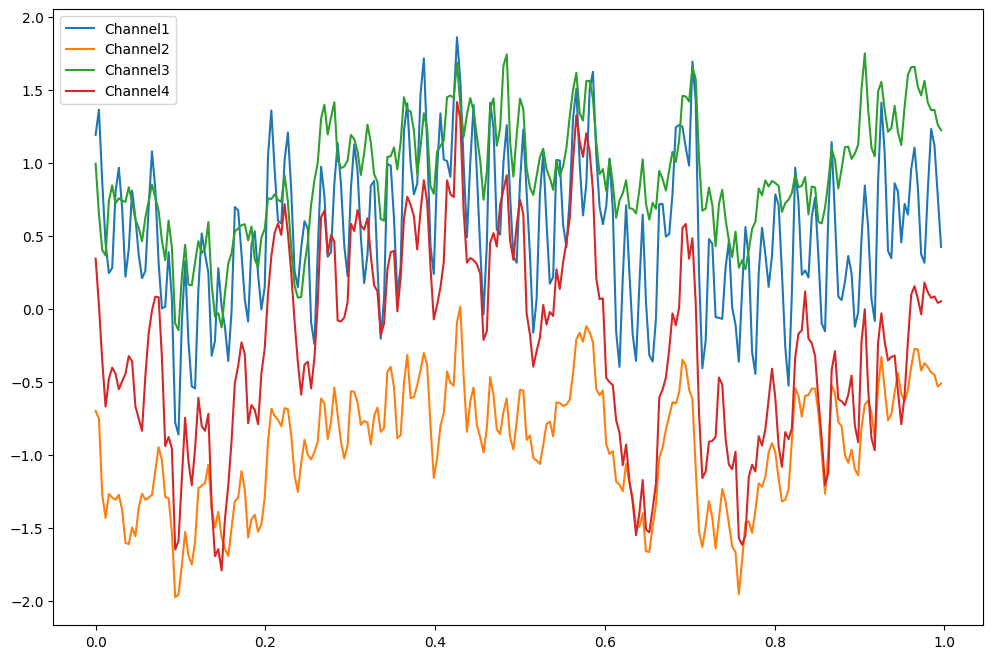

In [9]:
# plot first sample, first four channels
plot_channels(1, sample_train_data[0][:,:4])

## Depth = 12, output_dims = 320

### Callback functions

In [ ]:
def pretrain_callback(model, loss):
    n = model.pretrain_n_epochs
    metrics_dict = {}
    if n % 1 == 0:
        metrics_dict = eval_classification(model, sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], fraction=1)
        print(metrics_dict)
        # f1 = metrics_dict['F1']
        # if loss < model.min_loss:
        # if f1 > model.linear_f1:
    # if n == 100: # save the last epoch
        # model.min_loss = loss
        # model.linear_f1 = f1
        model.save(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")
    return metrics_dict['F1']

In [ ]:
def fine_tine_callback(model, f1, fraction=None):
    n = model.finetune_n_epochs
    if n % 1 == 0:
        # if loss < model.min_loss:
        if f1 > model.finetune_f1:
            # model.min_loss = loss
            model.finetune_f1 = f1
            if fraction:
                model.finetune_save(f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_encoder_model.pt",f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_proj_head_model.pt")
            else:
                fraction = 1.0
                model.finetune_save(f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_encoder_model.pt",f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_proj_head_model.pt")
    return fine_tine_callback

## Self-Supervised

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The program will run on {device}!")

In [ ]:
start_time = datetime.now()
# Train a TS2vec model
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=33,
    device=device,
    lr=0.0001,
    depth=12,
    trial_batch_size=15,
    output_dims=320,
    after_epoch_callback=pretrain_callback,
)

epoch_loss_list, epoch_f1_list = model.fit(
    trial_train_data,
    trial_train_labels, # patient ID is required
    overlapping=sample_overlapping,
    verbose=True,
    n_epochs=100,
    masks = ['all_true', 'all_true', 'continuous', 'continuous'],
    factors = [0.25, 0.25, 0.15, 0.35]
)

end_time = datetime.now()
print(f'Duration: {end_time - start_time}')

In [ ]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

## Linear evaluation and Finetune

In [ ]:
start_time = datetime.now()
seed_everything(RANDOM_SEED)
pretrain_model = COMET(
    input_dims=33,
    device=0,
    lr=0.0001,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

pretrain_model.finetune_f1 = -float('inf')

pretrain_model.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")

start_logging(RANDOM_SEED, logging_directory)
val_metrics_dict = eval_classification(pretrain_model, sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], fraction=1)
print("Linear evaluation for validation set\n",val_metrics_dict)
test_metrics_dict = eval_classification(pretrain_model, sample_train_data, sample_train_labels[:, 0], sample_test_data, sample_test_labels[:, 0], fraction=1)
print("Linear evaluation for test set\n",test_metrics_dict)
print()
stop_logging()

In [ ]:
seed_everything(RANDOM_SEED)
fraction = 1.0
epoch_loss_list, epoch_f1_list = pretrain_model.finetune_fit(sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], encoding_window='full_series',finetune_epochs=50, finetune_lr=0.0001, fraction=fraction)

In [ ]:
seed_everything(RANDOM_SEED)
finetune_model = COMET(
    input_dims=33,
    device=0,
    lr=0.0001,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

finetune_model.finetune_f1 = -float('inf')

finetune_model.finetune_load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_encoder_model.pt",f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_proj_head_model.pt")

start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {fraction} fraction of validation set")
finetune_model.finetune_predict(sample_val_data, sample_val_labels[:,0], mask=None, encoding_window='full_series')
print(f"Finetune for {fraction} fraction of test set")
finetune_model.finetune_predict(sample_test_data, sample_test_labels[:,0], mask=None, encoding_window='full_series')
print()
stop_logging()

In [ ]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

## Semi-supervised

### 30% label

In [ ]:
seed_everything(RANDOM_SEED)
pretrain_model = COMET(
    input_dims=33,
    device=0,
    lr=0.0001,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

pretrain_model.finetune_f1 = -float('inf')

pretrain_model.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")

In [ ]:
seed_everything(RANDOM_SEED)
fraction = 0.3
epoch_loss_list, epoch_f1_list = pretrain_model.finetune_fit(sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], encoding_window='full_series',finetune_epochs=50, finetune_lr=0.0001, fraction=fraction)

In [ ]:
seed_everything(RANDOM_SEED)
finetune_model = COMET(
    input_dims=33,
    device=0,
    lr=0.0001,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

finetune_model.finetune_f1 = -float('inf')

finetune_model.finetune_load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_encoder_model.pt",f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_proj_head_model.pt")

start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {fraction} fraction of validation set")
finetune_model.finetune_predict(sample_val_data, sample_val_labels[:,0], mask=None, encoding_window='full_series')
print(f"Finetune for {fraction} fraction of test set")
finetune_model.finetune_predict(sample_test_data, sample_test_labels[:,0], mask=None, encoding_window='full_series')
print()
stop_logging()

In [ ]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

### 10% label

In [ ]:
seed_everything(RANDOM_SEED)
pretrain_model = COMET(
    input_dims=33,
    device=0,
    lr=0.0001,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

pretrain_model.finetune_f1 = -float('inf')

pretrain_model.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")

In [ ]:
seed_everything(RANDOM_SEED)
fraction = 0.1
epoch_loss_list, epoch_f1_list = pretrain_model.finetune_fit(sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], encoding_window='full_series',finetune_epochs=100, finetune_lr=0.0001, fraction=fraction)

In [ ]:
seed_everything(RANDOM_SEED)
finetune_model = COMET(
    input_dims=33,
    device=0,
    lr=0.0001,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

finetune_model.finetune_f1 = -float('inf')

finetune_model.finetune_load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_encoder_model.pt",f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_proj_head_model.pt")

start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {fraction} fraction of validation set")
finetune_model.finetune_predict(sample_val_data, sample_val_labels[:,0], mask=None, encoding_window='full_series')
print(f"Finetune for {fraction} fraction of test set")
finetune_model.finetune_predict(sample_test_data, sample_test_labels[:,0], mask=None, encoding_window='full_series')
print()
stop_logging()

In [ ]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

### 1% label

In [ ]:
seed_everything(RANDOM_SEED)
pretrain_model = COMET(
    input_dims=33,
    device=0,
    lr=0.0005,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

pretrain_model.finetune_f1 = -float('inf')

pretrain_model.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")

In [ ]:
seed_everything(RANDOM_SEED)
fraction = 0.01
epoch_loss_list, epoch_f1_list = pretrain_model.finetune_fit(sample_train_data, sample_train_labels[:, 0], sample_val_data, sample_val_labels[:, 0], encoding_window='full_series',finetune_epochs=100, finetune_lr=0.0001, fraction=fraction)

In [ ]:
seed_everything(RANDOM_SEED)
finetune_model = COMET(
    input_dims=33,
    device=0,
    lr=0.0005,
    depth=12,
    sample_batch_size=128,
    output_dims=320,
    after_epoch_callback=fine_tine_callback,
)

finetune_model.finetune_f1 = -float('inf')

finetune_model.finetune_load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_encoder_model.pt",f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_proj_head_model.pt")

start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {fraction} fraction of validation set")
finetune_model.finetune_predict(sample_val_data, sample_val_labels[:,0], mask=None, encoding_window='full_series')
print(f"Finetune for {fraction} fraction of test set")
finetune_model.finetune_predict(sample_test_data, sample_test_labels[:,0], mask=None, encoding_window='full_series')
print()
stop_logging()

In [ ]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

In [ ]:
end_time = datetime.now()
print(f'Duration: {end_time - start_time}')